# Training EfficientNet

In [4]:
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB1  # or another EfficientNet version
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


X_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy")
y_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy")

X_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_val_256x192.npy")
y_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/val_labels.npy")

X_train.shape, X_val.shape
y_train.shape, y_val.shape

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
# y_train.shape, y_val.shape


pretrained_model = EfficientNetB1(input_shape=(192, 256, 3), include_top=False,weights='imagenet')

for layer in pretrained_model.layers:
    print(layer.name)
    layer.trainable = False
    
# print(len(pretrained_model.layers))

# for i, layer in enumerate(pretrained_model.layers):
#     print(i, layer.name)


2025-05-10 09:36:18.171527: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add

In [5]:
last_layer = pretrained_model.get_layer('top_activation')
print('Last layer output shape:', last_layer.output.shape)
last_output = last_layer.output


Last layer output shape: (None, 6, 8, 1280)


In [7]:
import tensorflow as tf

# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model = Model(pretrained_model.input, x)
#change epsilon from NONE to 1e-7, this helps not to divide by xero
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy',
#                        tf.keras.metrics.Precision(name='precision'),
#                        tf.keras.metrics.Recall(name='recall')])


train_datagenerator = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagenerator.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [8]:
batch_size = 64 
epochs = 3
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))                    


/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5073 - loss: 3.4002 - precision: 0.5156 - recall: 0.4784 - val_accuracy: 0.6540 - val_loss: 1.2381 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.6406 - loss: 1.1922 - precision: 0.6667 - recall: 0.4375

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6406 - loss: 1.1922 - precision: 0.6667 - recall: 0.4375 - val_accuracy: 0.6629 - val_loss: 1.1957 - val_precision: 0.6629 - val_recall: 0.6629
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6682 - loss: 1.1990 - precision: 0.6715 - recall: 0.5654 - val_accuracy: 0.7031 - val_loss: 1.0818 - val_precision: 0.7031 - val_recall: 0.7031


In [9]:
# Freeze the first 240 layers (~70%)
for layer in model.layers[:240]:
    layer.trainable = False

# Unfreeze the last 100 layers (~30%)
for layer in model.layers[240:]:
    layer.trainable = True


# reconfiguring and compling model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])  

In [11]:
# decreasing learning rate when model is stuck(not improving)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

batch_size = 64
epochs = 15
history = model.fit(train_datagenerator.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[lr_reduction])                                            

                          

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.6012 - loss: 1.4583 - precision: 0.6370 - recall: 0.5142 - val_accuracy: 0.6719 - val_loss: 1.3823 - val_precision: 0.6719 - val_recall: 0.6719 - learning_rate: 1.0000e-04
Epoch 2/15
  1/126 ━━━━━━━━━━━━━━━━━━━━ 5:33 3s/step - accuracy: 0.6250 - loss: 1.3932 - precision: 0.6000 - recall: 0.4219

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6250 - loss: 1.3932 - precision: 0.6000 - recall: 0.4219 - val_accuracy: 0.6652 - val_loss: 1.4203 - val_precision: 0.6652 - val_recall: 0.6652 - learning_rate: 1.0000e-04
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.6730 - loss: 1.2277 - precision: 0.6823 - recall: 0.5312 - val_accuracy: 0.6674 - val_loss: 1.1445 - val_precision: 0.6674 - val_recall: 0.6674 - learning_rate: 1.0000e-04
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6719 - loss: 1.1520 - precision: 0.6875 - recall: 0.5156 - val_accuracy: 0.6830 - val_loss: 1.1367 - val_precision: 0.6830 - val_recall: 0.6830 - learning_rate: 1.0000e-04
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.6659 - loss: 1.2226 - precision: 0.6694 - recall: 0.5286 - val_accuracy: 0.6674 - val_loss: 1.1437 - val_precision: 0.6674 - val_recall: 0.6674 - learning_rate: 1.0000e-04
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step

In [12]:
results = model.evaluate(X_val, y_val, verbose=1)
loss_val = results[0]
acc_val = results[1]
precision_val = results[2]
recall_val = results[3]

print("Validation: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (acc_val, loss_val, precision_val, recall_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 793ms/step - accuracy: 0.6765 - loss: 1.1708 - precision: 0.9683 - recall: 0.3336
Validation: accuracy = 0.665188  ;  loss = 1.186145  ;  precision = 0.973684  ;  recall = 0.328160


# Testing EfficientNet

In [14]:
X_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_test_256x192.npy")

y_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/test_labels.npy")
y_test = to_categorical(y_test)


results = model.evaluate(X_test, y_test, verbose=1)

# Unpack individual metrics from the results list
loss_test = results[0]
accuracy_test = results[1]
precision_test = results[2]
recall_test = results[3]

print("Test: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (accuracy_test, loss_test, precision_test, recall_test))

# loss_test, accuracy_test = model.evaluate(X_test, y_test,? verbose=1)
# print("Test: accuracy = %f  ;  loss = %f" % (accuracy_test, loss_test))

model.save("EfficientNet.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 808ms/step - accuracy: 0.6641 - loss: 1.2021 - precision: 0.9764 - recall: 0.2820


Test: accuracy = 0.676647  ;  loss = 1.177900  ;  precision = 0.980769  ;  recall = 0.305389


Text(0.5, 1.0, 'Training and validation loss')

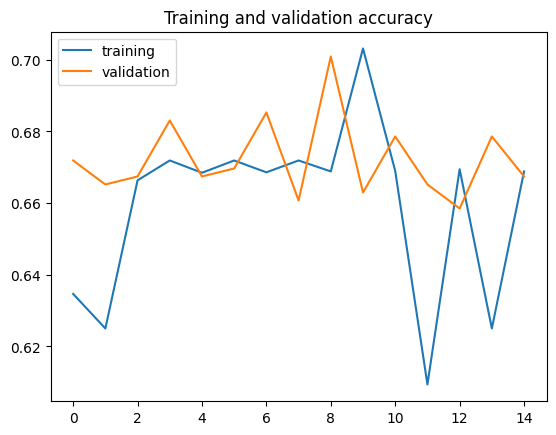

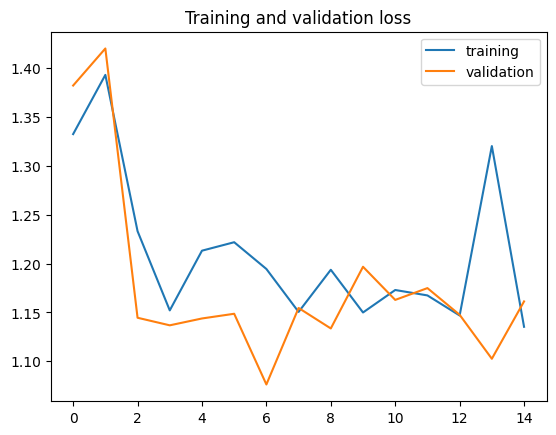

: 

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label="training")
plt.plot(epochs, val_loss, label="validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
